# Tarea 2: Calculo de puntos de interes. 


In [2]:
import os.path 
try:
  import google.colab as colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Cargamos los datos solo la primera vez que nos conectamos a la "runtime":
# La descarga se hace automatica desde un repo en github
if IN_COLAB:
  if os.path.exists('/content/imagenes_tarea_2.zip'):
    print("Datos ya descargados")
  else:
    !wget https://github.com/Diego-II/Procesamiento-Avanzado-de-Imagenes/raw/master/Tarea2/imagenes_tarea_2.zip
    !unzip /content/imagenes_tarea_2

Datos ya descargados


In [7]:
!ls

imagenes_parte_2  imagenes_parte_3  imagenes_tarea_2.zip  sample_data


In [8]:
!pip install ipython-autotime

In [ ]:
%load_ext autotime

In [ ]:
!pip install -U opencv-python

**Parte 2**

In [5]:
%load_ext Cython

Para el calculo de los gradientes, se utilizara el siguiente metodo:
\begin{equation}
 {G} _{x}={\begin{bmatrix}+1&0&-1\\+2&0&-2\\+1&0&-1\end{bmatrix}}*\mathbf {A} \quad {\mbox{and}}\quad \mathbf {G} _{y}={\begin{bmatrix}+1&+2&+1\\0&0&0\\-1&-2&-1\end{bmatrix}}*\mathbf {A} 
\end{equation}

In [44]:
%%cython
import cython
import numpy as np
cimport numpy as np
from scipy import signal


cpdef float[:, :] gradx(float [:, :] input):
  # POR HACER: calcular el gradiente en x
  cdef np.ndarray output=np.zeros([input.shape[0], input.shape[1]], dtype = np.float32)
  cdef np.ndarray kernel = np.array(([-1, 0, 1],[-2, 0, 2],[-1, 0, 1]), dtype="int")

  output = np.float32(signal.convolve2d(input, kernel, mode = 'same', boundary = 'fill', fillvalue = 0))

  return output

In [45]:
%%cython
import cython
import numpy as np
cimport numpy as np
from scipy import signal

cpdef float[:, :] grady(float [:, :] input):
  # POR HACER: Calcular el gradiente en y
  cdef np.ndarray output=np.zeros([input.shape[0], input.shape[1]], dtype = np.float32)
  cdef np.ndarray kernel = np.array(([-1, -2, -1],[0, 0, 0],[1, 2, 1]), dtype="int")
  output = np.float32(signal.convolve2d(input, kernel, mode = 'same', boundary = 'fill', fillvalue = 0))
  return output

In [42]:
%%cython
import cython
import numpy as np
cimport numpy as np

cpdef float[:, :] product(float [:, :] input1, float [:, :] input2):
  # POR HACER: generar una matriz que contenga el producto entre input1 e input2, pixel a pixe
  cdef int rows, cols,
  cdef np.ndarray output=np.zeros([input1.shape[0], input1.shape[1]], dtype = np.float32)
  rows, cols = input1.shape[0], input1.shape[1]

  for i in range(rows):
    for j in range(cols):
      output[i,j] = input1[i,j] * input2[i,j]

  return np.float32(output)

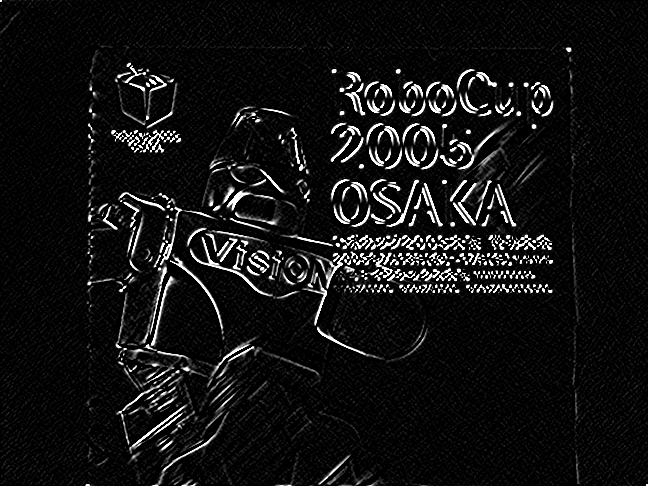

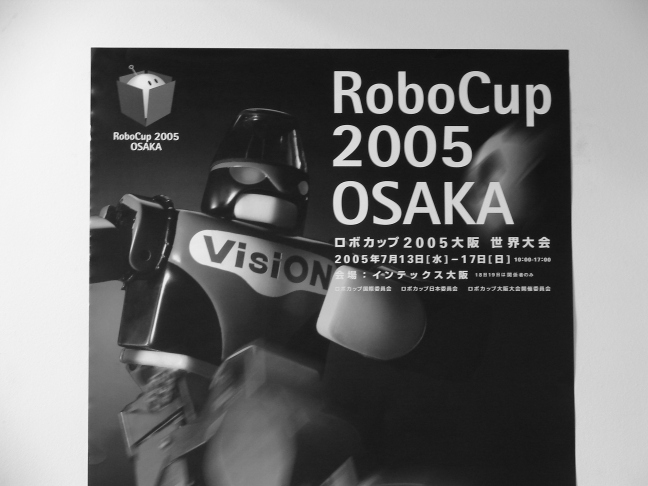

In [49]:
import cv2
from google.colab.patches import cv2_imshow
#img1 = cv2.imread('imagenes_parte_2/uch006a.jpg',0)
originalRGB = cv2.imread('imagenes_parte_2/uch006a.jpg') #Leer imagen


if len(originalRGB.shape) == 3:
  original = cv2.cvtColor(originalRGB, cv2.COLOR_BGR2GRAY)
else:
  original = originalRGB

input = np.float32( original )
cv2_imshow(np.float32(input))

out = grady(gradx(input))
cv2_imshow(np.float32(out))


In [88]:
%%cython
import cython
import numpy as np
cimport numpy as np
from __main__ import product

cpdef float[:, :] harris(float [:, :] mxx, float [:, :] mxy, float [:, :] myy):
  '''
  Args:
  mxx: momento xx de la imagen
  myy: momento yy de la imagen 
  mxy: momento xy de la imagen
  '''
  # POR HACER: Calcular el filtro de Harris a partir de (mxx, mxy, myy)
  cdef float det, tr, 
  cdef int rows, cols, 
  cdef np.ndarray output = np.zeros([mxx.shape[0], mxx.shape[1]], dtype = np.float32)
  rows, cols = mxx.shape[0], mxx.shape[1]
  
  for i in range(rows):
    for j in range(cols):
      det = product(mxx, myy) - product(mxy,mxy)
      tr = mxx.add( myy )
      output[i,j] = det - 0.04 * tr*tr

  return output

In [93]:
%%cython
import cython
import numpy as np
cimport numpy as np
from libc.math cimport sqrt
from __main__ import product

cpdef float[:, :] shiTomasi(float [:, :] mxx, float [:, :] mxy, float [:, :] myy):
  # POR HACER: Calcular el filtro de Shi-Tomasi a partir de (mxx, mxy, myy)
  cdef float det, tr, rows, cols, 
  cdef np.ndarray output = np.zeros([mxx.shape[0], mxx.shape[1]], dtype = np.float32)
  rows, cols = mxx.shape[0], mxx.shape[1]
  
  for i in range(rows):
    for j in range(cols):
      det = product(mxx, myy) - product(mxy,mxy)
      tr = mxx.add( myy )
      output[i,j] = tr/2 - sqrt(tr*tr - 4*det)/2

  return output

In [70]:
%%cython
import cython
import numpy as np
cimport numpy as np

# Funcion auxiliar para obtener el maximo de los vecinos. 
def get_h(h, i, j, rows, cols):
  output = h[max(i-1, 0):min(i+2, rows), max(j-1, 0):min(j+2, cols)].flatten()
  return np.float32(np.amax(output))

cpdef float[:, :] getMaxima(float [:, :] h, float val):
  # POR HACER: Crear una imagen, inicialmente llena con ceros.
  # Luego, hacer 1 los valores en los cuales:
  #   h[r,c] sea un maximo local respecto a sus 8 vecinos
  #   h[r,c] supera el valor val
  cdef int rows, cols,
  cdef np.ndarray output=np.zeros([h.shape[0], h.shape[1]], dtype = np.float32)
  rows, cols = h.shape[0], h.shape[1]

  for i in range(rows):
    for j in range(cols):
      max_vecino = np.float32(get_h(h, i, j, rows, cols))
      if (max_vecino >= val):
        output[i,j] = 1


  return np.float32(output)

In [71]:
# Esta funcion genera keypoints a partir de una imagen de entrada
# La imagen de entrada puede ser la salida del filtro de Harris o el de Shi-Tomasi
# No es necesario modificar esta funcion
def getKeyPoints(input):
  output = []
  input_rows = input.shape[0]
  input_cols = input.shape[1]
  for r in range(input_rows):
    for c in range(input_cols):
      if input[r,c] > 0:
        kp = cv2.KeyPoint()
        kp.pt = (c,r)
        kp.size = 10
        kp.angle = 0
        output.append(kp)
  return output

In [94]:
from cv2 import GaussianBlur
from __main__ import product
def harrisDetector(input, val):
  input = np.float32( input )
  # Por hacer: calcular el filtro de Harris
  # Hay que realizar los siguientes pasos:
  # 1) Suavizar la imagen de entrada con cv.GaussianBlur( )
  I_soft = GaussianBlur(input, (3,3), 0)
  # 2) Calcular gradientes imx e imy (usando funciones de cython definidas arriba)
  Ix , Iy = gradx(I_soft), grady(I_soft)
  # 3) Calcular momentos usando la funcion product( )
  #    imxx = imx*imx (pixel a pixel)
  Ixx = GaussianBlur(np.float32(product(Ix, Ix)), (3,3), 0)
  Iyy = GaussianBlur(np.float32(product(Iy, Iy)), (3,3), 0)
  Ixy = GaussianBlur(np.float32(product(Ix, Iy)), (3,3), 0)
  #    imxy = imx*imy (pixel a pixel)
  #    imyy = imy*imy (pixel a pixel)
  # 4) Suavizar momentos imxx, imxy, imyy con cv.GaussianBlur( )
  #    => Puede requerir transformar las imagenes de Cython a Python usando np.float32( )
  # 5) Aplicar el filtro de Harris (usando funcion de Cython definida arriba)
  harris_f = harris(Ixx, Ixy, Iyy)
  # 6) Encontrar puntos maximos usando getMaxima( )
  maximos = getMaxima(harris_f, val)
  # Harris -> 2e8, shitomasi -> 7e3
  # 7) Generar el listado de puntos usando getKeyPoints( )
  # 8) Devolver los puntos e interes y la imagen filtrada
  points = getKeyPoints(maximos)
  
  return points, np.float32(harris_f)

In [ ]:
def shiTomasiDetector(input, val):
  input = np.float32( input )
  # Por hacer: calcular el filtro de Shi-Tomasi
  # El procedimiento es similar al de la funcion de arriba
  # Sin embargo, se debe llamar al filtro de Shi-Tomasi en vez del de Harris

  h = input    # Esta linea debe ser eliminada
  points = []  # Esta linea debe ser eliminada
  return points, np.float32(h)
  return points, np.float32(h)

In [74]:
def do_rotate(img, angle):
  h = img.shape[0]
  w = img.shape[1]
  cx = w // 2
  cy = h // 2
  m = cv2.getRotationMatrix2D((cx, cy), -angle, 1.0)
  cosa = np.cos(angle * np.pi / 180.0)
  sina = np.sin(angle * np.pi / 180.0)
  nw = int((h * sina) + (w * cosa))
  nh = int((h * cosa) + (w * sina))
  m[0,2] += (nw / 2) - cx
  m[1,2] += (nh / 2) - cy
  return cv2.warpAffine(img, m, (nw, nh))

In [95]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

img1 = cv2.imread('imagenes_parte_2/uch006a.jpg',0) 
img2 = do_rotate(img1, 30)

kp1, h1 = harrisDetector(img1, 3e7)
kp2, h2 = harrisDetector(img2, 3e7)

res1 = cv2.drawKeypoints(img1, kp1, img1, None, cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
res2 = cv2.drawKeypoints(img2, kp2, img2, None, cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

print('Resultados de filtro de Harris')
cv2_imshow(h1 * 100 / np.max(np.max(h1)))
cv2_imshow(h2 * 100 / np.max(np.max(h2)))
print('Puntos de interes')
cv2_imshow(res1)
cv2_imshow(res2)


TypeError: ignored

**Parte 3**

In [ ]:
# Esta funcion ya esta lista, no debe ser modificada
def filterMatches(matches):
  # Apply ratio test
  points1 = []
  points2 = []
  good = []

  for m,n in matches:
    if m.distance < 0.75*n.distance:  # 0.75
      good.append([m])
      points1.append(kp1[m.queryIdx].pt)
      points2.append(kp2[m.trainIdx].pt)
  return np.array(points1), np.array(points2), good

In [77]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

img1 = cv2.imread('left2.jpg',0)
img2 = cv2.imread('right2.jpg',0)

detector = cv2.SIFT_create()

(kp1, des1) = detector.detectAndCompute(img1,None)
(kp2, des2) = detector.detectAndCompute(img2,None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

points1, points2, good = filterMatches(matches)

img_match = cv2.drawMatchesKnn(img1, kp1, img2, kp2,
                                good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
cv2_imshow(img_match)

# El objetivo del codigo que sigue es alinear dos imagenes

# 1) Por hacer: calcular la homografia usando cv2.findHomography( ) con parametro cv2.RANSAC

# 2) Por hacer: transformar la imagen img2 usando la funcion warpPerspective( ) y la homografia
#   La imagen de salida debe tener un tamano suficiente
#   Se recomienda que tenga el doble del ancho de la imagen de entrada

# 3) Por hacer: copiar la imagen img1 a la imagen resultante del paso anterior (se obtiene la imagen fusionada)

# 4) Por hacer: mostrar la imagen fusionada

error: ignored